# Example - 08 - Venus Aerocapture: Part 4

In this example, you will learn to create a drag modulation aerocapture feasibility chart for Venus.

For reference, we will re-create another figure from the paper "Girija, Lu, and Saikia, Feasibility and Mass-Benefit Analysis of Aerocapture for Missions to Venus, Journal of Spacecraft and Rockets, Vol. 57, No. 1" DOI: 10.2514/1.A34529

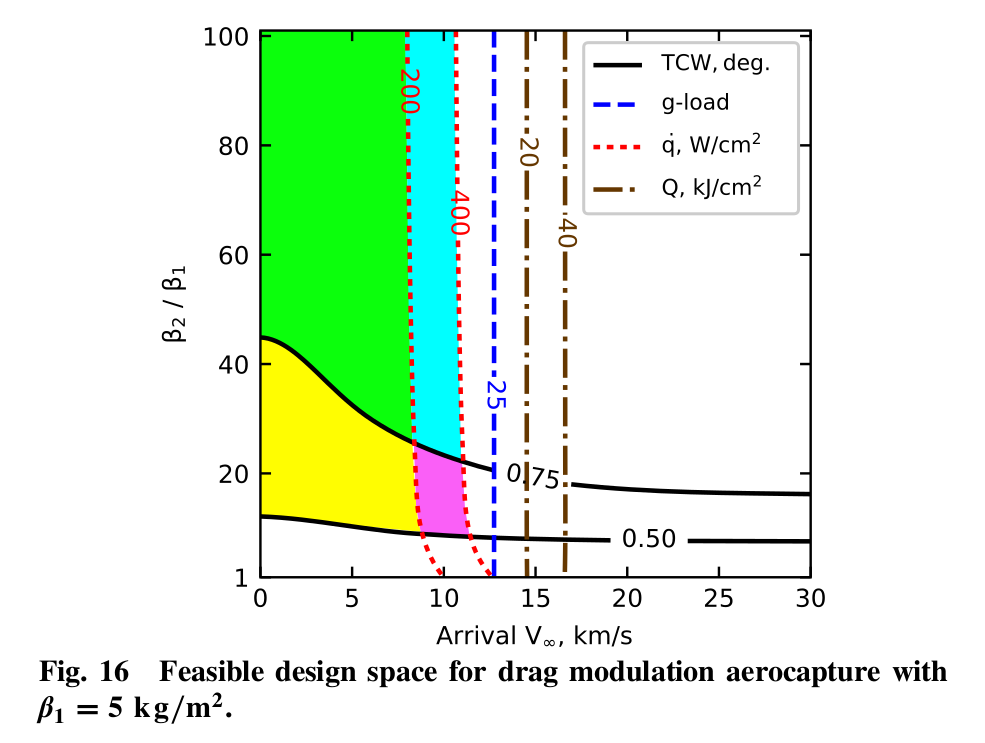

In [1]:
from IPython.display import Image
Image(filename='../plots/girijaYe2020c-reference.png', width=600)

In [2]:
from AMAT.planet import Planet
from AMAT.vehicle import Vehicle

import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Polygon
import os

In [3]:
# Create a planet object
planet=Planet("VENUS")    
planet.h_skip = 150000.0 

# Load an nominal atmospheric profile with height, temp, pressure, density data
planet.loadAtmosphereModel('../atmdata/Venus/venus-gram-avg.dat', 0 , 1 ,2, 3)

vinf_kms_array  = np.linspace( 0.0,   30.0,   11)
betaRatio_array = np.linspace( 1.0,   101.0 , 11)

#vinf_kms_array  = np.linspace( 0.0,   30.0,   2)
#betaRatio_array = np.linspace( 1.0,   101.0 , 2)

In [4]:
beta1 = 5.0

os.makedirs('../data/girijaYe2019c')
runID = 'DMBC5RAP400EI150'

In [5]:
v0_kms_array    = np.zeros(len(vinf_kms_array))
v0_kms_array[:] = np.sqrt(1.0*(vinf_kms_array[:]*1E3)**2.0 + 2*np.ones(len(vinf_kms_array))*planet.GM/(planet.RP+150.0*1.0E3))/1.0E3

overShootLimit_array  = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
underShootLimit_array = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
exitflag_os_array     = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
exitflag_us_array     = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
TCW_array             = np.zeros((len(v0_kms_array),len(betaRatio_array))) 


In [6]:
for i in range(0,len(v0_kms_array)):
    for j in range(0,len(betaRatio_array)):
        vehicle=Vehicle('DMVehicle', 1500.0, beta1, 0.0, 3.1416, 0.0, 0.10, planet)
        vehicle.setInitialState(150.0,0.0,0.0,v0_kms_array[i],0.0,-4.5,0.0,0.0)
        vehicle.setSolverParams(1E-6)
        vehicle.setDragModulationVehicleParams(beta1,betaRatio_array[j])

        underShootLimit_array[i,j], exitflag_us_array[i,j] = vehicle.findUnderShootLimitD(2400.0, 0.1, -80.0,-4.0,1E-10,400.0)
        overShootLimit_array[i,j] , exitflag_os_array[i,j] = vehicle.findOverShootLimitD (2400.0, 0.1, -80.0,-4.0,1E-10,400.0)

        TCW_array[i,j]    = overShootLimit_array[i,j] - underShootLimit_array[i,j]

        print('VINF: '+str(vinf_kms_array[i])+' km/s, BETA RATIO: '+str(betaRatio_array[j])+' TCW: '+str(TCW_array[i,j])+' deg.')

np.savetxt('../data/girijaYe2019c/'+runID+'vinf_kms_array.txt',vinf_kms_array)				
np.savetxt('../data/girijaYe2019c/'+runID+'v0_kms_array.txt',v0_kms_array)		
np.savetxt('../data/girijaYe2019c/'+runID+'betaRatio_array.txt',betaRatio_array)		
np.savetxt('../data/girijaYe2019c/'+runID+'overShootLimit_array.txt',overShootLimit_array)
np.savetxt('../data/girijaYe2019c/'+runID+'exitflag_os_array.txt',exitflag_os_array)
np.savetxt('../data/girijaYe2019c/'+runID+'underShootLimit_array.txt',underShootLimit_array)
np.savetxt('../data/girijaYe2019c/'+runID+'exitflag_us_array.txt',exitflag_us_array)
np.savetxt('../data/girijaYe2019c/'+runID+'TCW_array.txt',TCW_array)


VINF: 0.0 km/s, BETA RATIO: 1.0 TCW: 0.0 deg.
VINF: 0.0 km/s, BETA RATIO: 101.0 TCW: 0.8981981236029242 deg.
VINF: 30.0 km/s, BETA RATIO: 1.0 TCW: 0.0 deg.
VINF: 30.0 km/s, BETA RATIO: 101.0 TCW: 1.192248803385155 deg.


In [8]:
acc_net_g_max_array       = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
stag_pres_atm_max_array   = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
q_stag_total_max_array    = np.zeros((len(v0_kms_array),len(betaRatio_array))) 
heatload_max_array        = np.zeros((len(v0_kms_array),len(betaRatio_array))) 


for i in range(0,len(v0_kms_array)):
    for j in range(0,len(betaRatio_array)):
        vehicle=Vehicle('DMVehicle', 1500.0, beta1, 0.0, 3.1416, 0.0, 0.10, planet)
        vehicle.setInitialState(150.0,0.0,0.0,v0_kms_array[i],0.0,overShootLimit_array[i,j],0.0,0.0)
        vehicle.setSolverParams(1E-6)

        vehicle.propogateEntry (2400.0, 0.1, 0.0)

        # Extract and save variables to plot
        t_min_os         = vehicle.t_minc
        h_km_os          = vehicle.h_kmc
        acc_net_g_os     = vehicle.acc_net_g
        q_stag_con_os    = vehicle.q_stag_con
        q_stag_rad_os    = vehicle.q_stag_rad
        rc_os            = vehicle.rc
        vc_os            = vehicle.vc
        stag_pres_atm_os = vehicle.computeStagPres(rc_os,vc_os)/(1.01325E5) 
        heatload_os      = vehicle.heatload


        vehicle=Vehicle('DMVehicle', 1500.0, beta1*betaRatio_array[j], 0.0, 3.1416, 0.0, 0.10, planet)
        vehicle.setInitialState(150.0,0.0,0.0,v0_kms_array[i],0.0,underShootLimit_array[i,j],0.0,0.0)
        vehicle.setSolverParams( 1E-6)

        vehicle.propogateEntry (2400.0, 0.1, 0.0)

        # Extract and save variable to plot
        t_min_us         = vehicle.t_minc
        h_km_us          = vehicle.h_kmc
        acc_net_g_us     = vehicle.acc_net_g
        q_stag_con_us    = vehicle.q_stag_con
        q_stag_rad_us    = vehicle.q_stag_rad
        rc_us            = vehicle.rc
        vc_us            = vehicle.vc
        stag_pres_atm_us = vehicle.computeStagPres(rc_us,vc_us)/(1.01325E5) 
        heatload_us      = vehicle.heatload

        q_stag_total_os  = q_stag_con_os + q_stag_rad_os
        q_stag_total_us  = q_stag_con_us + q_stag_rad_us

        acc_net_g_max_array[i,j]      = max(max(acc_net_g_os),max(acc_net_g_us)) 
        stag_pres_atm_max_array[i,j]  = max(max(stag_pres_atm_os),max(stag_pres_atm_os))
        q_stag_total_max_array[i,j]   = max(max(q_stag_total_os),max(q_stag_total_us)) 
        heatload_max_array[i,j]       = max(max(heatload_os),max(heatload_us))

        print("V_infty: "+str(vinf_kms_array[i])+" km/s"+", BR: "+str(betaRatio_array[j])+" G_MAX: "+str(acc_net_g_max_array[i,j])+" QDOT_MAX: "+str(q_stag_total_max_array[i,j])+" J_MAX: "+str(heatload_max_array[i,j])+" STAG. PRES: "+str(stag_pres_atm_max_array[i,j]))

np.savetxt('../data/girijaYe2019c/'+runID+'acc_net_g_max_array.txt',acc_net_g_max_array)
np.savetxt('../data/girijaYe2019c/'+runID+'stag_pres_atm_max_array.txt',stag_pres_atm_max_array)
np.savetxt('../data/girijaYe2019c/'+runID+'q_stag_total_max_array.txt',q_stag_total_max_array)
np.savetxt('../data/girijaYe2019c/'+runID+'heatload_max_array.txt',heatload_max_array)


V_infty: 0.0 km/s, BR: 1.0 G_MAX: 4.2619678756684065 QDOT_MAX: 107.04783114721339 J_MAX: 9963.95886102549 STAG. PRES: 0.00206384918146089
V_infty: 0.0 km/s, BR: 101.0 G_MAX: 4.2619678756684065 QDOT_MAX: 1069.8045659113661 J_MAX: 105153.41622997135 STAG. PRES: 0.00206384918146089
V_infty: 30.0 km/s, BR: 1.0 G_MAX: 143.43437041606074 QDOT_MAX: 763604.549664235 J_MAX: 4964898.795992032 STAG. PRES: 0.06941820444237855
V_infty: 30.0 km/s, BR: 101.0 G_MAX: 143.43437041606074 QDOT_MAX: 182872814.4356986 J_MAX: 1231040818.2242763 STAG. PRES: 0.06941820444237855


/home/athul/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


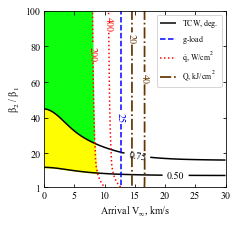

In [9]:
x = np.loadtxt('../data/girijaYe2019c/'+runID+'vinf_kms_array.txt')
y = np.loadtxt('../data/girijaYe2019c/'+runID+'betaRatio_array.txt')

Z1 = np.loadtxt('../data/girijaYe2019c/'+runID+'TCW_array.txt')
G1 = np.loadtxt('../data/girijaYe2019c/'+runID+'acc_net_g_max_array.txt')
Q1 = np.loadtxt('../data/girijaYe2019c/'+runID+'q_stag_total_max_array.txt')
H1 = np.loadtxt('../data/girijaYe2019c/'+runID+'heatload_max_array.txt')
S1 = np.loadtxt('../data/girijaYe2019c/'+runID+'stag_pres_atm_max_array.txt')


f1 = interpolate.interp2d(x, y, np.transpose(Z1), kind='cubic')	
g1 = interpolate.interp2d(x, y, np.transpose(G1), kind='cubic')
q1 = interpolate.interp2d(x, y, np.transpose(Q1), kind='cubic')
h1 = interpolate.interp2d(x, y, np.transpose(H1), kind='cubic')
s1 = interpolate.interp2d(x, y, np.transpose(S1), kind='cubic')


x_new =  np.linspace( 0.0,   30,  110)
y_new =  np.linspace( 0.0,   101 ,110)

z1_new =  np.zeros((len(x_new),len(y_new)))
g1_new =  np.zeros((len(x_new),len(y_new)))
q1_new =  np.zeros((len(x_new),len(y_new)))
h1_new =  np.zeros((len(x_new),len(y_new)))
s1_new =  np.zeros((len(x_new),len(y_new)))

for i in range(0,len(x_new)):
    for j in range(0,len(y_new)):

        z1_new[i,j] = f1(x_new[i],y_new[j])
        g1_new[i,j] = g1(x_new[i],y_new[j])
        q1_new[i,j] = q1(x_new[i],y_new[j])
        h1_new[i,j] = h1(x_new[i],y_new[j])
        s1_new[i,j] = s1(x_new[i],y_new[j])


Z1 = z1_new
G1 = g1_new
Q1 = q1_new
S1 = s1_new
H1 = h1_new/1000.0

X, Y = np.meshgrid(x_new, y_new)

Zlevels = np.array([0.5,0.75])
Glevels = np.array([25.0])
Qlevels = np.array([200.0, 400.0])
Hlevels = np.array([20.0,40.0])

fig = plt.figure()
fig.set_size_inches([3.25,3.25])
plt.ion()
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

ZCS1 = plt.contour(X, Y, np.transpose(Z1), levels=Zlevels, colors='black')
plt.clabel(ZCS1, inline=1, fontsize=10, colors='black',fmt='%.2f',inline_spacing=1)
ZCS1.collections[0].set_linewidths(1.50)
ZCS1.collections[1].set_linewidths(1.50)
ZCS1.collections[0].set_label(r'$TCW, deg.$')

GCS1 = plt.contour(X, Y, np.transpose(G1), levels=Glevels, colors='blue',linestyles='dashed')
Glabels=plt.clabel(GCS1, inline=1, fontsize=10, colors='blue',fmt='%d',inline_spacing=0)
GCS1.collections[0].set_linewidths(1.50)

GCS1.collections[0].set_label(r'$g$'+r'-load')

QCS1 = plt.contour(X, Y, np.transpose(Q1), levels=Qlevels, colors='red',linestyles='dotted',zorder=11)
plt.clabel(QCS1, inline=1, fontsize=10, colors='red',fmt='%d',inline_spacing=0)
QCS1.collections[0].set_linewidths(1.50)
QCS1.collections[1].set_linewidths(1.50)
QCS1.collections[0].set_label(r'$\dot{q}$'+', '+r'$W/cm^2$')


HCS1 = plt.contour(X, Y, np.transpose(H1), levels=Hlevels, colors='xkcd:brown',linestyles='dashdot')
Hlabels=plt.clabel(HCS1, inline=1, fontsize=10, colors='xkcd:brown',fmt='%d',inline_spacing=0)
HCS1.collections[0].set_linewidths(1.75)
HCS1.collections[1].set_linewidths(1.75)
HCS1.collections[0].set_label(r'$Q$'+', '+r'$kJ/cm^2$')

for l in Hlabels:
    l.set_rotation(-90)
for l in Glabels:
    l.set_rotation(-90)


#SCS1 = plt.contour(X, Y, transpose(S1), levels=Slevels, colors='cyan')
#plt.clabel(SCS1, inline=1, fontsize=10, colors='xkcd:neon green',fmt='%.1f',inline_spacing=1)
#SCS1.collections[0].set_linewidths(1.75)
#SCS1.collections[0].set_label(r'$Peak$'+r' '+r'$stag. pressure,atm$')

plt.xlabel("Arrival "+r'$V_\infty$'+r', km/s' ,fontsize=10)
plt.ylabel(r'$\beta_2$'+' / '+r'$ \beta_1 $' ,fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(np.array([ 1, 20, 40, 60, 80, 100]),fontsize=10)
ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.legend(loc='upper right', fontsize=8)


dat0 = ZCS1.allsegs[1][0]
x1,y1=dat0[:,0],dat0[:,1]
F1 = interpolate.interp1d(x1, y1, kind='linear',fill_value='extrapolate', bounds_error=False)

dat1 = QCS1.allsegs[0][0]
x2,y2=dat1[:,0],dat1[:,1]
F2 = interpolate.interp1d(x2, y2, kind='linear',fill_value='extrapolate', bounds_error=False)

dat0a = ZCS1.allsegs[0][0]
x1a,y1a=dat0a[:,0],dat0a[:,1]
F1a = interpolate.interp1d(x1a, y1a, kind='linear',fill_value='extrapolate', bounds_error=False)


x3 = np.linspace(0,30,301)
y3 = F1(x3)
y4 = F2(x3)
y4a =F1a(x3)

y8 = np.minimum(y3,y4)


plt.fill_between(x3, y3, y4, where=y3<=y4, color='xkcd:neon green')
plt.fill_between(x3, y4a, y8, where=y4a<=y8, color='xkcd:bright yellow')

plt.xlim([0.0,30.0])
plt.ylim([1.0,100])


plt.savefig('../plots/girijaYe2019c-fig16.png',bbox_inches='tight')
plt.savefig('../plots/girijaYe2019c-fig16.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../plots/girijaYe2019c-fig16.eps', dpi=300,bbox_inches='tight')

plt.show()

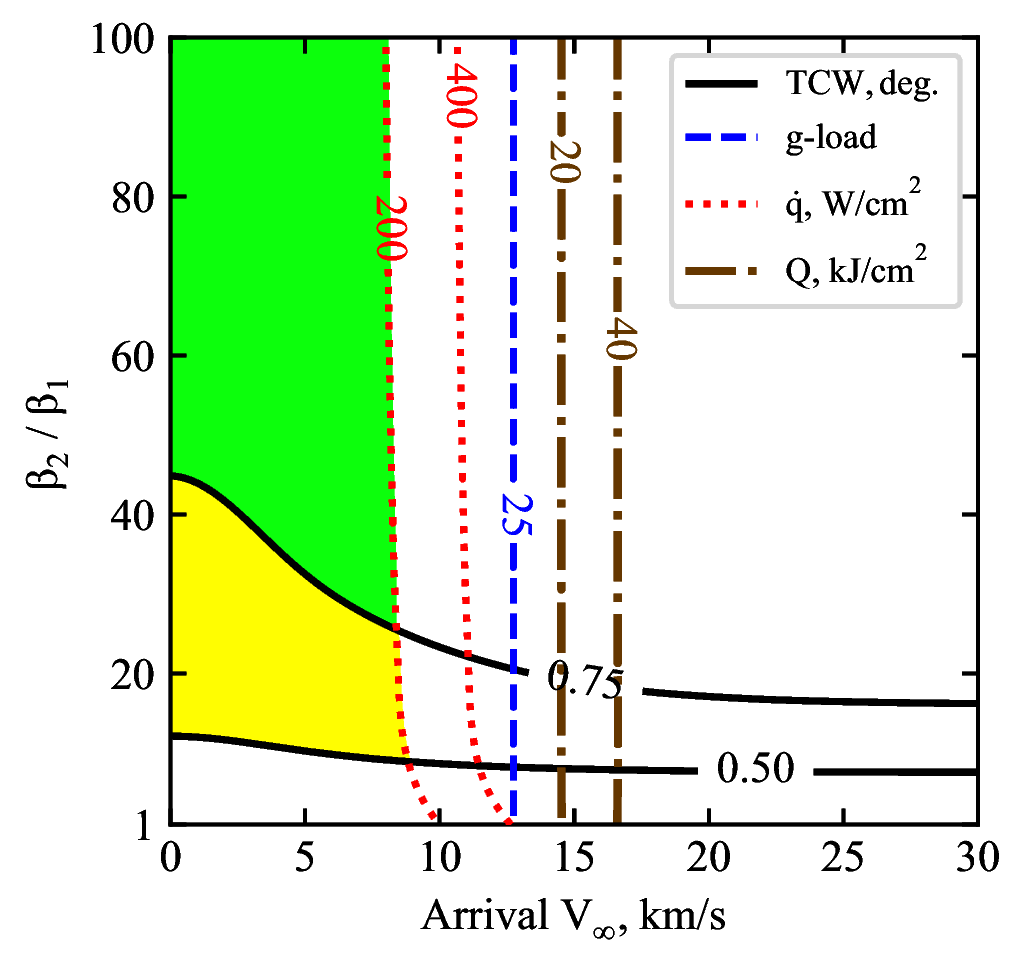

In [10]:
from IPython.display import Image
Image(filename='../plots/girijaYe2020c-higher-res.png', width=600)

The plots are now saved in plots/girijaYe2019c.

**Congratulations!** You could now create the results for referenced journal article in less than a day. It took nearly a year for the authors to put everything together to create these results!